<a href="https://colab.research.google.com/github/erezimm/ML-ML/blob/master/DeepSet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main notebook, to be run on Google Colab

## Import dependencies and download dataset

In [1]:
!pip install dgl

import glob
import os
import shutil
from datetime import datetime

import astropy.io.ascii
import dgl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

if not torch.cuda.is_available():
    raise Exception('Cuda unavailable, turn it on under Runtime>Change runtime type>GPU')
device = torch.device('cuda')

!wget -O /content/master https://www.dropbox.com/s/8mplpd13feqijag/master?dl=1



# validation_path = '/content/valid/data'
# training_path = '/content/train/data'
# data_path = '/content/data/data'
# microlist = glob.glob(data_path+'/microlensedconst_*')
# varlist = glob.glob(data_path+'/cleanvar_*')
# for typelist in (microlist, varlist):
#     for i, f in enumerate(typelist):
#         dest = training_path if i<len(microlist)/2 else validation_path
#         shutil.move(f, os.path.join(dest, os.path.basename(f)))

     |████████████████████████████████| 3.0MB 2.3MB/s 


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
--2020-08-18 15:28:05--  https://www.dropbox.com/s/8mplpd13feqijag/master?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.1, 2620:100:6023:1::a27d:4301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/8mplpd13feqijag/master [following]
--2020-08-18 15:28:05--  https://www.dropbox.com/s/dl/8mplpd13feqijag/master
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0e2e5d1a08d9d0409ad4544e7b.dl.dropboxusercontent.com/cd/0/get/A9tF6OvgjnulrIwmmaJT-g2mAOmyFUK2SFArbfBYtJV2Z-dkz_AqKrYcLCuYUm3sf1iRi-SarKpwH22Z3dNADzKlngiUJEp1E-ImyRsfqkDa-E56pu--7UugaOBn5m8CzAQ/file?dl=1# [following]
--2020-08-18 15:28:06--

In [2]:
N = 20000
truelist, falselist = [], []
with open('/content/master','r') as f:
    for datum in tqdm(f.read().split('---\n')):
        if len(falselist)>=2*N and len(truelist)>=2*N:
            break
        times, mags, magerrs = [],[],[]
        for i, l in enumerate(datum.splitlines()):
            if i>0:
                t,mag,magerr = l.split()
                t,mag,magerr = float(t),float(mag),float(magerr)
                times.append(t)
                mags.append(mag)
                magerrs.append(magerr)
        if datum.startswith('microlensed\n') and len(truelist)<2*N: 
            truelist.append((times, mags, magerrs))
        elif len(falselist)<2*N: 
            falselist.append((times, mags, magerrs))

print('Microlensed:',len(truelist),'Non:',len(falselist))



true1, false1 = truelist[:N], falselist[:N]
true2, false2 = truelist[N:], falselist[N:]
del truelist
del falselist

Microlensed: 40000 Non: 40000


## Create Datasets
Class CustomDataset loads all files and converts them to a list of graphs.
Each node in a graph is a data point, i.e. node features are days since start, mag, magerr

In [3]:
a=[1,2,3,4,5,6]
a[2:4]

[3, 4]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



train: tensor([20000]) tensor([19999])


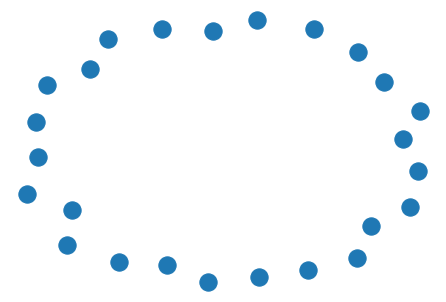

In [4]:
class CustomDataset(Dataset):
    def __init__(self, truelist,falselist):
        self.graphs = []
        self.isMicrolensed = []

        listdict = {True:truelist, False:falselist}
        for k in (False, True):
            for times, mags, magerrs in tqdm(listdict[k]):
                times, mags, magerrs =torch.tensor(times), torch.tensor(mags), torch.tensor(magerrs)

                if len(times)==0:
                    continue

                times = times - min(times)
                flux = 10 ** (mags/(-2.5))
                medflux = torch.median(flux)
                flux = flux/medflux
                fluxerr = flux * magerrs * np.log(10) * 0.4 / medflux

                n = len(times)
                g = dgl.DGLGraph()
                g.add_nodes(n)
                g.ndata['time'] = torch.tensor(times).float()  # days
                g.ndata['mag'] = torch.tensor(flux).float()
                g.ndata['magerr'] = torch.tensor(fluxerr).float()


                #g.add_edges([i for i in range(n)], [(i+1)%n for i in range(n)])
                #g.add_edges([i for i in range(n)], [(i-1)%n for i in range(n)])
                
                self.graphs.append(g)
                self.isMicrolensed.append(torch.tensor([1]) if k else torch.tensor([0]))
        
    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], self.isMicrolensed[idx]



train_ds = CustomDataset(true1, false1)
del true1
del false1

validation_ds = CustomDataset(true2, false2)
del true2
del false2

nx.draw(dgl.to_networkx(train_ds[20][0]))

trainflags = [0+a for _, a in train_ds]
print('train:', sum(trainflags), len(trainflags)-sum(trainflags))



In [5]:
def collate(samples):
    # The input `samples` is a list, a batch of whatever comes out of your dataset object
    graphs = [x[0] for x in samples]
    labels = [x[1] for x in samples]
    
    batched_graph = dgl.batch(graphs, node_attrs=['time', 'mag', 'magerr'])
    targets = torch.cat(labels)

    return batched_graph, targets.unsqueeze(1).float()

## The Network

In [6]:
layers = [10,10]  # hidden layers in the DeepSetLayer
outputsize = 7  # length of the representation passed to the final network
cllayers = [10,5,5]  # hidden layers in the final network (takes outputsize, returns a scalar which is the classification)

In [7]:
def build_layers(inp,out,sizes):
    sizes = [inp]+sizes+[out]
    layers = []
    for i in range(len(sizes)-1):
        layers.extend([nn.Linear(sizes[i], sizes[i+1]), nn.LeakyReLU()])
    
    return layers

In [8]:
# #Deep Set

class DeepSet(nn.Module):

    def __init__(self, config):
        super(DeepSet, self).__init__()

        self.config = config

        self.layers = nn.ModuleList()

        self.layers.append(DeepSetLayer(config['inputsize'], config['layers'][0], config['inputs'], config['output'] ))

        n_layers = len(config['layers'])

        for i in range(n_layers - 1):

            self.layers.append(DeepSetLayer(config['inputsize']+ config['layers'][i],
                                            config['layers'][i+1], 
                                            config['inputs'] + [config['output']], 
                                            config['output']))
            

        self.layers.append(DeepSetLayer(config['inputsize']+ config['layers'][-1],
                                            config['outputsize'], 
                                            config['inputs'] + [config['output']],
                                            config['output']))  

        layers = build_layers(config['outputsize'], 2, config['cllayers'])  # OFEK chnaged to output=2
        self.classifier = nn.Sequential(*(layers+ [nn.Softmax()]))  # OFEK added SoftMax
    
    def forward(self, g):

        for layer in self.layers:
            
            g = layer(g) 

        mean_nodes= dgl.mean_nodes(g, 'node_embed', weight = None)
        output = self.classifier(mean_nodes)


        return output 


In [9]:
class DeepSetLayer(nn.Module):
    def __init__(self, inputsize, outputsize, inputnames, outputname):
        


        super(DeepSetLayer,self).__init__()

        self.inputs      = inputnames
        self.outputname = outputname


  

        layers = build_layers(inputsize, outputsize, [int(0.5*(outputsize + inputsize)   )])

        self.node_embedd = nn.Sequential(*layers)

        layers = build_layers(outputsize + inputsize, outputsize,[ int( 0.5*(outputsize + inputsize)) ] )

        self.node_update = nn.Sequential(*layers)



    def forward(self, g):

        gn = [g.ndata[inputname] for inputname in self.inputs]
        unsqdim = max(max([len(n.shape) for n in gn]),2)
        tocat = []
        for n in gn:
            t = n
            for _ in range(unsqdim-len(n.shape)):
                t = t.unsqueeze(-1)
            tocat.append(t)
            # print(t.shape)
        node_data = torch.cat(tocat, dim=1)

        g.ndata['node_embed'] = self.node_embedd(node_data)


        node_sum = dgl.mean_nodes(g, 'node_embed', weight = None)  #Global representation of graph 

        g.ndata['mean_nodes'] = dgl.broadcast_nodes(g, node_sum)
        
        

        gn = [g.ndata[inputname] for inputname in self.inputs] + [g.ndata['mean_nodes']]
        unsqdim = max(max([len(n.shape) for n in gn]),2)
        tocat = []
        for n in gn:
            t = n
            for _ in range(unsqdim-len(n.shape)):
                t = t.unsqueeze(-1)
            tocat.append(t)
            # print(t.shape)
        node_update_input = torch.cat( tocat, dim=1  )

        g.ndata[self.outputname] = self.node_update(node_update_input)


        return g #contains global information 


In [15]:
net = DeepSet({'inputsize':3 , 'outputsize':outputsize, 'inputs':['time', 'mag', 'magerr'], 'output':'finalrep', 'layers':layers, 'cllayers':cllayers})
net.to(device)

DeepSet(
  (layers): ModuleList(
    (0): DeepSetLayer(
      (node_embedd): Sequential(
        (0): Linear(in_features=3, out_features=6, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=6, out_features=10, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
      )
      (node_update): Sequential(
        (0): Linear(in_features=13, out_features=6, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=6, out_features=10, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): DeepSetLayer(
      (node_embedd): Sequential(
        (0): Linear(in_features=13, out_features=11, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=11, out_features=10, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
      )
      (node_update): Sequential(
        (0): Linear(in_features=23, out_features=11, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        

In [16]:
def evaluate(net, validation_ds):
    test_data_loader = DataLoader(validation_ds, batch_size=1000, shuffle=True, collate_fn=collate)

    net.cpu()
    net.eval()

    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    total_positives = 0
    total_negatives = 0

    for i, (x,y) in enumerate(test_data_loader):
            y = y.data.numpy()
            y = y.transpose()
            prediction = net(x).cpu().data.numpy()
            pred = (prediction[:,1]>prediction[:,0])
            
            total_positives+=len(np.where( y==1 )[0])
            total_negatives+=len(np.where( y==0 )[0])
            

            true_positive+= len(np.where( (pred==1) & (y==1) )[0])
            false_positive+= len(np.where( (pred==1) & (y==0) )[0])
    # print(pred, prediction, y)
    if total_positives:
        print('Probability of detection:', true_positive/total_positives)  # probability of recognizing a microlensing when you see it
    else:
        print('no positives')
    if total_negatives:
        print('Probability of false alarm:', false_positive/total_negatives)  # probability for misclassification of a variable star as microlensing
    else:
        print('no negatives')

## Train

In [ ]:
# options:
# loss_func = nn.BCEWithLogitsLoss()
# loss_func = nn.L1Loss()
loss_func = nn.CrossEntropyLoss()
#optimizer = optim.Adadelta(net.parameters(), lr=1)
#optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

n_epochs = 100

losses = []
epoch_valid_loss=[]

data_loader = DataLoader(train_ds, batch_size=1000, shuffle=True, collate_fn=collate)
valid_dl = DataLoader(train_ds, batch_size=1000, shuffle=True, collate_fn=collate)
for epoch in tqdm(range(n_epochs)):
    net.train()
    this_losses = []
    for x,y in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = net(x)
        # print(output)
        # output = torch.cat((1-output, output), dim=1)
        # print(output)
        loss = loss_func(output.squeeze(), y.long().squeeze())
        this_losses.append(float(loss))
        loss.backward()
        optimizer.step()
    
    losses.append(np.mean(this_losses))

    net.eval()
    this_losses = []
    for x,y in valid_dl:

        x = x.to(device)
        y = y.to(device)
        pred = net(x)
        valid_loss = loss_func(pred.squeeze(),y.long().squeeze())
        this_losses.append(float(valid_loss))

    epoch_valid_loss.append(np.mean(this_losses))

    
    print('Epoch:', epoch, 'Trainign Loss:', round(losses[-1], 4), 'validloss:', round(epoch_valid_loss[-1],4))  # for some real-time indication (couldn't manage to get this to dynamically plot)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 0 Trainign Loss: 0.8121 validloss: 0.8117
Epoch: 1 Trainign Loss: 0.8111 validloss: 0.8103
Epoch: 2 Trainign Loss: 0.8095 validloss: 0.8085
Epoch: 3 Trainign Loss: 0.7933 validloss: 0.6825
Epoch: 4 Trainign Loss: 0.6687 validloss: 0.6595
Epoch: 5 Trainign Loss: 0.6578 validloss: 0.657
Epoch: 6 Trainign Loss: 0.6571 validloss: 0.6575
Epoch: 7 Trainign Loss: 0.6572 validloss: 0.657
Epoch: 8 Trainign Loss: 0.6574 validloss: 0.6569


In [ ]:
# plot the printed losses:
losses = np.array(losses)
plt.plot(losses[1:],label='training loss')
plt.plot(epoch_valid_loss[1:],label='valid loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()




In [ ]:
del train_ds


nx.draw(dgl.to_networkx(validation_ds[20][0]))
validflags = [0+a for _, a in validation_ds]
print('valid:', sum(validflags), len(validflags)-sum(validflags))
evaluate(net, validation_ds)

## Save
Don't forget to download

In [ ]:
timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
torch.save(net.state_dict(), 'model_' + timestamp + '.pt')

## Validate on the confirmed microlensing events

In [ ]:
!wget -O /content/confirmed_microlensing.zip https://github.com/erezimm/ML-ML/raw/master/confirmed_microlensing.zip
!unzip -o -q -d /content/ confirmed_microlensing.zip

In [ ]:
class CustomDatasetPATH(Dataset):
    def __init__(self, path):
        filelist = glob.glob(path+'/*')
        self.graphs = []
        self.isMicrolensed = []
        for fname in tqdm(filelist):
            filebasename = os.path.basename(fname)
            if filebasename.startswith('cleanvar'):
                microlensed = torch.tensor([0])
            elif filebasename.startswith('microlensedconst'):
                microlensed = torch.tensor([1])
            else:
                microlensed = torch.tensor([1])
            with open(fname) as f:
                data = astropy.io.ascii.read(f.read())
                times, mags, magerrs = data['col1'], [], data['col3']
                for m, err in zip(data['col2'], magerrs):
                    mags.append(round(m, len(str(err).split('.')[1])))
                zipped = list(zip(times, mags, magerrs))
                zipped.sort(key=lambda tup: tup[0])
                times, mags, magerrs = zip(*zipped)
                times, mags, magerrs =torch.tensor(times), torch.tensor(mags), torch.tensor(magerrs)
                times = times - min(times)
                flux = 10 ** (mags/(-2.5))
                medflux = torch.median(flux)
                flux = flux/medflux
                fluxerr = flux * magerrs * np.log(10) * 0.4 / medflux
                n = len(times)
                g = dgl.DGLGraph()
                g.add_nodes(n)
                g.ndata['time'] = torch.tensor(times).float()  # days
                g.ndata['mag'] = torch.tensor(flux).float()
                g.ndata['magerr'] = torch.tensor(fluxerr).float()
                #g.add_edges([i for i in range(n)], [(i+1)%n for i in range(n)])
                #g.add_edges([i for i in range(n)], [(i-1)%n for i in range(n)])
                self.graphs.append(g)
                self.isMicrolensed.append(microlensed)
    def __len__(self):
        return len(self.graphs)
    def __getitem__(self, idx):
        return self.graphs[idx], self.isMicrolensed[idx]

conf_ds = CustomDatasetPATH('/content/confirmed_microlensing')
# print(len(conf_ds))
nx.draw(dgl.to_networkx(conf_ds[20][0]))



In [ ]:
evaluate(net, conf_ds)